# Install dependencies

In [2]:
!pip install essentia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 29.7 MB/s eta 0:00:00


In [3]:
!pip install mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100704 sha256=f1a1858f9be49dc1ef7eab37731be730ef9aaa2809ce1765ea4fec493f993863
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


In [4]:
!pip install mido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [5]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=77c0314199a5235afb5bf511ac6a1a18838639a7e0ea4892040d4be67c868875
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


# Import

In [6]:
import librosa
import essentia.standard as es
import mido
import pretty_midi
import mir_eval.display
from mir_eval.sonify import pitch_contour



import numpy as np
import matplotlib.pyplot as plt
import IPython

In [7]:
%matplotlib inline

## Import Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Chrissi file path
path = 'drive/MyDrive/Colab Notebooks/audios/'
fileName = 'stayin-alive-100bpm-30s'
ext = '.mp3'

Audio

# Essentia

In [10]:
# Recommended: Apply equal-loudness filter for PredominantPitchMelodia.
loader = es.EqloudLoader(filename=path+fileName+ext, sampleRate=44100)
audio = loader()
print(f"Duration of audio sample [sec]: {len(audio)/44100.0}")

Duration of audio sample [sec]: 30.048956916099772


In [11]:
# PitchMelodia takes  entire audio signal as input.
pitch_extractor = es.PredominantPitchMelodia(frameSize=2048, hopSize=128, guessUnvoiced=True)
pitch_values, pitch_confidence = pitch_extractor(audio)

# Pitch estimated on frames -> compute frame time positions.
pitch_times = np.linspace(0.0,len(audio)/44100.0,len(pitch_values))

In [12]:
tmpAudio = path + 'results/' + 'syn_' + fileName + ext

# Essentia operates with float32 ndarrays instead of float64, so let's cast it.
synthesized_melody = pitch_contour(pitch_times, pitch_values, 44100).astype(np.float32)[:len(audio)]
es.AudioWriter(filename=tmpAudio, format='mp3')(es.StereoMuxer()(audio, synthesized_melody))

In [13]:
onsets, durations, notes = es.PitchContourSegmentation(hopSize=128)(pitch_values, audio)
print("MIDI notes:", notes) # Midi pitch number
print("MIDI note onsets:", onsets)
print("MIDI note durations:", durations)

MIDI notes: [51. 58. 56. 51. 41. 48. 58. 51. 41. 57. 46. 48. 51. 54. 53. 44. 48. 47.
 46. 46. 49. 46. 58. 55. 55. 58. 53. 46. 58. 46. 75. 58. 58. 58. 56. 54.
 51. 48. 47. 51. 48. 47. 48. 41. 53. 53. 64. 57. 54. 71. 69. 56. 70. 71.
 72. 63. 62. 70. 65. 60. 68. 68. 68. 70. 78. 65. 66. 68. 60. 58. 64. 51.
 64. 60. 63. 65. 65. 66. 56. 47. 41. 69. 72. 87. 72. 71. 72. 71. 71. 51.
 68. 69. 68. 68. 62. 70. 65. 61. 65. 65. 68. 68. 75. 70. 65. 65. 65. 66.
 65. 72. 68. 80. 68. 70. 70. 46. 53. 70. 58. 70. 70. 62. 66. 62. 55. 70.
 69. 68. 69. 70. 71. 72. 54. 56. 65. 70. 70. 72.]
MIDI note onsets: [ 1.5238096  1.6282994  1.9040363  2.3655329  2.6441724  2.9431293
  3.2391837  3.5149207  3.9096599  4.249252   4.687528   5.0039
  5.2564173  5.5118365  5.6163263  5.8282084  6.0081635  6.1126533
  6.211338   6.405805   6.7250795  6.8295693  7.2678456  7.8338323
  7.932517   8.031201   8.321451   8.4317465  8.565261   8.66975
  9.015147   9.113832   9.499864  10.170341  11.221043  11.61288
 11.71737   12

In [14]:
PPQ = 96 # Pulses per quarter note.
BPM = 120 # Assuming a default tempo in Ableton to build a MIDI clip.
tempo = mido.bpm2tempo(BPM) # Microseconds per beat.

# Compute onsets and offsets for all MIDI notes in ticks.
# Relative tick positions start from time 0.
offsets = onsets + durations
silence_durations = list(onsets[1:] - offsets[:-1]) + [0]

mid = mido.MidiFile()
track = mido.MidiTrack()
mid.tracks.append(track)

for note, onset, duration, silence_duration in zip(list(notes), list(onsets), list(durations), silence_durations):
    track.append(mido.Message('note_on', note=int(note), velocity=64,
                              time=int(mido.second2tick(duration, PPQ, tempo))))
    track.append(mido.Message('note_off', note=int(note),
                              time=int(mido.second2tick(silence_duration, PPQ, tempo))))

midi_file = path + 'results/' + 'melody_' + fileName + '.mid'
mid.save(midi_file)
print("MIDI file location:", midi_file)

MIDI file location: drive/MyDrive/Colab Notebooks/audios/results/melody_stayin-alive-100bpm-30s.mid


## Pretty midi

In [15]:
# Piano roll (time-frequency matrix)
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [16]:
pm = pretty_midi.PrettyMIDI(midi_file)

<ipython-input-15-455600f4c246>:4: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


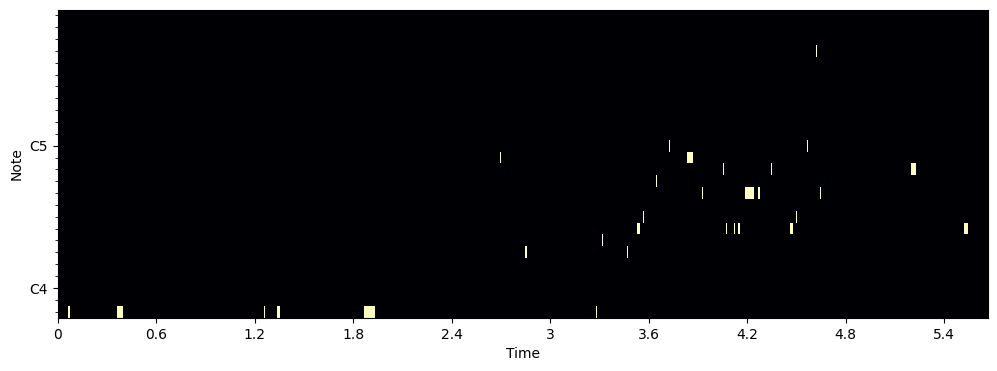

In [17]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 58, 84, fs=400)

In [18]:
# Let's look at what's in this MIDI file
print('There are {} time signature changes'.format(len(pm.time_signature_changes)))
print('There are {} instruments'.format(len(pm.instruments)))
print('Instrument 3 has {} notes'.format(len(pm.instruments[0].notes)))
#print('Instrument 4 has {} pitch bends'.format(len(pm.instruments[4].pitch_bends)))
#print('Instrument 5 has {} control changes'.format(len(pm.instruments[5].control_changes)))

There are 0 time signature changes
There are 1 instruments
Instrument 3 has 137 notes


## Analyizing MIDI data

### Harmonic information

pitch class histogram percentage values: [0.10948905 0.01459854 0.02919708 0.09489051 0.02189781 0.15328467
 0.06569343 0.02189781 0.13868613 0.05109489 0.22627737 0.0729927 ]
Number of emthy frames: 4637
number of all pitch values: 10354
Ratio of emthy frames: 0.44784624299787523
All non cero pitch values:  [160.12286, 158.28368, 158.28368, 158.28368, 158.28368, 158.28368, 159.20062, 159.20062, 160.12286, 159.20062, 159.20062, 158.28368, 158.28368, 157.37204, 156.46562, 156.46562, 156.46562, 157.37204, 157.37204, 157.37204, 158.28368, 159.20062, 159.20062, 160.12286, 160.12286, 160.12286, 160.12286, 159.20062, 160.12286, 160.12286, 161.05045, 163.86559, 167.69577, 171.61551, 172.60966, 174.61531, 175.62685, 175.62685, 176.64426, 176.64426, 176.64426, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 176.64426, 176.64426, 176.64426, 176.64426, 176.64426, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 177.66754, 177.667

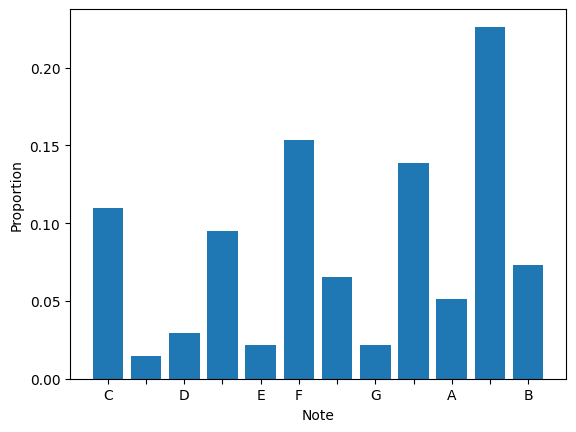

In [19]:
# Plot a pitch class distribution - sort of a proxy for key
pm = pretty_midi.PrettyMIDI(midi_file)
plt.bar(np.arange(12), pm.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')

pitch_class_histogram = pm.get_pitch_class_histogram()
print("pitch class histogram percentage values:",pitch_class_histogram)



#calculate absolute pitch class values
pitch_extractor = es.PredominantPitchMelodia()
pitch_values, pitch_confidence = pitch_extractor(audio)

empthy_frames = list(filter(lambda x: x == 0, pitch_values))
print("Number of emthy frames:",len(empthy_frames))

print("number of all pitch values:", len(pitch_values))

print("Ratio of emthy frames:",len(empthy_frames)/len(pitch_values))

pitchesE = list(filter(lambda x: x != 0, pitch_values))
print("All non cero pitch values: ", pitchesE)
print("Number of non-cero pitch values: ", len(pitchesE))

pitch_set = list(dict.fromkeys(pitchesE))
print("Unique pitch values:", pitch_set)
print("Number of unique pitch values:",len(pitch_set))



#absoluteClassValues = [i *  len(pitchesE) for i in pitch_class_histogram]
absoluteClassValues = [round(i * len(pitchesE)) for i in pitch_class_histogram]
print(absoluteClassValues)

pitch_class_histogram = pm.get_pitch_class_histogram()
pitch_class_histogram = [round(i,2) for i in pitch_class_histogram]
print(pitch_class_histogram)




### Util

In [20]:
print('Program number 42 is {}'.format(pretty_midi.program_to_instrument_name(42)))
print('... and has instrument class {}'.format(pretty_midi.program_to_instrument_class(42)))
print('Bassoon has program number {}'.format(pretty_midi.instrument_name_to_program('Bassoon')))

Program number 42 is Cello
... and has instrument class Strings
Bassoon has program number 70
